# Introduction 
This project consists in analysing the last 30 years measured wind in Dublin and the possible relationship to the climate change using the synoptic station in Dublin_Airport, Co Dublin. 
Source: https://data.gov.ie/dataset/dublin-airport-hourly-data

### 1.1 Preparing the environment
First, we must prepare the necessary working environment to start the analysis problem. This introductory section is divided as follows:
- Library installation.
- Load the dataset
- Check the data frame info 

In [42]:

# import pandas to use DataFrames
import pandas as pd

# import matplotlib to plot data representations
import matplotlib.pyplot as plt

# import seaborn to plot heatmaps
import seaborn as sns

# import numpy to use mathematical functions
import numpy as np



The first 23 lines of the source CSV contains non-csv metadata, that give some context on the database. 

In [43]:
# Read the first 23 lines of the CSV as text to display the metadata
with open("wind.csv", "r") as file:
    for i in range(23):
        print(file.readline().rstrip())

Station Name: DUBLIN AIRPORT
Station Height: 71 M
Latitude:53.428  ,Longitude: -6.241


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)
temp:  -  Air Temperature (C)
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none
clamt: -  Cloud amount
ind:   -  Indicator



### Variable Descriptions and Climate Change Analysis

Some of the available variables are useful for wind and climate change analysis, while others can be discarded. They can be categorized as follows:

#### Core Climate Variables

- **date**: Date and Time (UTC) - Temporal reference for all measurements, essential for trend analysis.
- **temp**: Air Temperature (°C) - Direct indicator of climate change; warming trends are a primary climate change signal.
- **rain**: Precipitation Amount (mm) - Important for understanding changes in precipitation patterns, intensity, and frequency related to climate change.
- **msl**: Mean Sea Level Pressure (hPa) - Reflects atmospheric circulation patterns; changes can indicate shifts in weather systems and storm tracks.
- **rhum**: Relative Humidity (%) - Measures atmospheric moisture content; important for understanding changes in water vapor (a key greenhouse gas feedback).
- **wdsp**: Mean Wind Speed (knots) - Wind patterns can shift with climate change and is also our main target of analysis.
- **wddir**: Predominant Wind Direction (degrees) - Can reveal shifts in prevailing wind patterns and atmospheric circulation regimes.

#### Atmospheric Moisture Variables:

- **dewpt**: Dew Point Temperature (°C) - Indicates absolute atmospheric moisture content; useful for understanding humidity changes over time
- **vappr**: Vapour Pressure (hPa) - Direct measure of atmospheric water vapor; important for understanding the hydrological cycle and greenhouse effect
- **wetb**: Wet Bulb Temperature (°C) - Derived from temperature and humidity; useful for heat stress analysis but less direct for climate trends

#### Solar Radiation Variable

- **sun**: Sunshine Duration (hours) - Related to solar radiation and cloud cover; can indicate changes in cloudiness patterns and solar energy availability

#### Weather Classification Variables

- **ww**: Synop Code for Present Weather - Categorical weather classification; less useful for quantitative climate trend analysis
- **w**: Synop Code for Past Weather - Historical weather classification; limited value for long-term climate analysis

Source: https://share.google/aimode/kygrfjkFQxoGu4PfZ

#### Atmospheric Visibility and Cloud Variables

- **vis**: Visibility (m) - Affected by fog, pollution, and precipitation; can indicate changes in air quality and atmospheric conditions
- **clht**: Cloud Height (100's of ft, 999 if none) - Cloud vertical structure; useful for understanding cloud cover changes
- **clamt**: Cloud Amount - Cloud coverage; important for understanding changes in cloudiness which affects radiation balance

#### Technical Variables

- **ind**: Indicator - Data quality flags or measurement indicators; not directly useful for climate analysis

### Ideal Variables for Multi-Variable Climate Change Analysis

- `temp` (Air Temperature) - Core climate indicator
- `rain` (Precipitation) - Hydrological cycle changes
- `wdsp` and `wddir` (Wind Speed and Wind Direction) - Wind measures
- `msl` (Mean Sea Level Pressure) - Atmospheric circulation
- `rhum` (Relative Humidity) - Greenhouse gas feedback

#### Analysis Approach
- Analyze wind patterns alone, in the last 30 years
- Correlate temperature trends with wind speed, precipitation, and pressure patterns
- Analyze relationships between humidity, temperature, and precipitation
- Examine pressure-wind relationships to understand circulation changes
- Investigate seasonal shifts in multiple variables simultaneously

### 1.1 Load and Clean Data

We will select only the columns that are directly related to wind speed and its climatic interpretation, renaming them to have understandable names.
And delete the columns we don't need for the aim of this analysis.

Filter the period required, 30 years, from 1995 to 2025, so we can ignore the years prior to this period.

As the dataset mesures the wind speed in knots. To follow the international standard, we change it to meters per second (m/s).

Source: https://share.google/aimode/Py9CUXm0ByMYwoZGp

In [44]:
# Load the dataset and prepare for analysis
df = pd.read_csv("wind.csv", skiprows=23, low_memory=False)

# Rename key columns
df = df.rename(columns={
    'date': 'date and time', 
    'temp': 'air temperature', 
    'wdsp': 'mean wind speed', 
    'wddir': 'wind direction',
    'msl': 'mean sea level pressure',
    'rhum': 'relative humidity',
    'rain': 'precipitation'
})

# Remove indicator columns and unused variables
df = df.loc[:, ~df.columns.str.startswith('ind')]
df = df.drop(columns=['wetb', 'dewpt', 'vappr', 'w', 'ww', 'vis', 'clht', 'clamt', 'sun'], errors='ignore')

# Convert date to datetime and set as index
df['date and time'] = pd.to_datetime(df['date and time'], format='%d-%b-%Y %H:%M')
df.set_index('date and time', inplace=True)
df = df.sort_index()

# Filter to 1995-2025 - remove ALL data before 1995-01-01
df = df[(df.index >= '1995-01-01') & (df.index <= '2025-12-31')]

# Convert wind speed from knots to m/s to adhere to the International System of Units
df['mean wind speed'] = df['mean wind speed'] * 0.514444

# Convert object columns to numeric where needed
for col in ['relative humidity', 'wind direction']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271729 entries, 1995-01-01 00:00:00 to 2025-12-31 00:00:00
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   precipitation            271729 non-null  float64
 1   air temperature          271729 non-null  float64
 2   relative humidity        271728 non-null  float64
 3   mean sea level pressure  271729 non-null  float64
 4   mean wind speed          271729 non-null  float64
 5   wind direction           271728 non-null  float64
dtypes: float64(6)
memory usage: 14.5 MB


In [46]:
# Display the first rows to get a clue of the data
df.head()

,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
date and time,,,,,,
1995-01-01 00:00:00,0.0,-0.7,98.0,1012.3,5.658884,280.0
1995-01-01 01:00:00,0.0,-0.8,98.0,1012.7,5.658884,280.0
1995-01-01 02:00:00,0.0,-1.2,100.0,1013.7,5.658884,280.0
1995-01-01 03:00:00,0.0,-1.3,100.0,1013.9,4.629996,270.0
1995-01-01 04:00:00,0.0,-0.5,100.0,1014.1,5.144440,270.0


In [47]:
df.tail()

,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
date and time,,,,,,
2025-12-30 20:00:00,0.0,4.6,79.0,1037.0,2.572220,90.0
2025-12-30 21:00:00,0.0,2.4,86.0,1036.9,2.057776,50.0
2025-12-30 22:00:00,0.0,0.5,88.0,1036.9,2.057776,10.0
2025-12-30 23:00:00,0.0,0.1,90.0,1037.0,2.057776,20.0
2025-12-31 00:00:00,0.0,1.5,91.0,1037.0,1.543332,290.0


## 2. Wind Speed Analysis

### 2.1 Annual and Seasonal Trends

Wind Speed Trend: -0.0224 m/s per year (-0.22 m/s per decade)

Decade Averages:
  1995-2004: 5.34 m/s
  2005-2014: 5.57 m/s
  2015-2024: 5.02 m/s
  Change (1995-2004 to 2015-2024): -6.13%


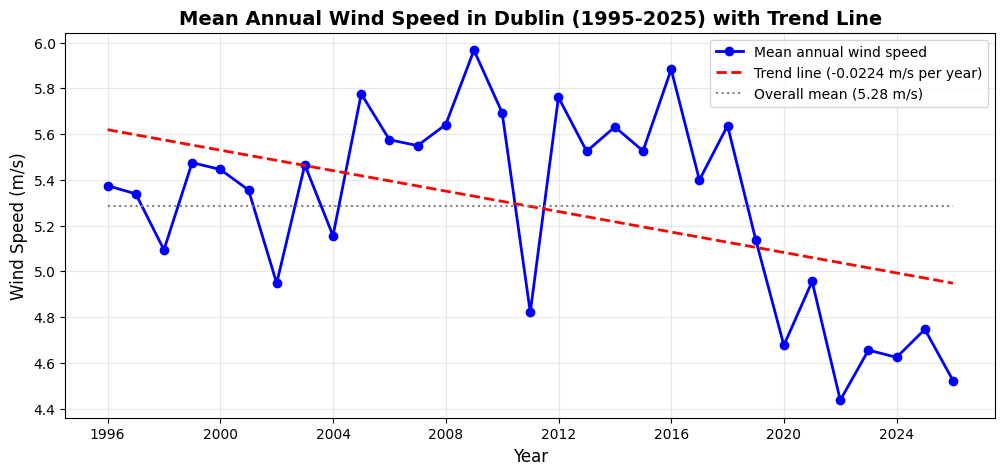

In [48]:
# Calculate annual and seasonal statistics
df_yearly = df.resample('YE')['mean wind speed'].mean()
df_yearly_max = df.resample('YE')['mean wind speed'].max()

# Calculate trend using linear regression
# Convert dates to numeric years for regression
years = df_yearly.index.year.values.astype(float)
wind_speeds = df_yearly.values

# Calculate linear regression
slope, intercept = np.polyfit(years, wind_speeds, 1)
trend = slope  # m/s per year
trend_decade = trend * 10  # m/s per decade

# Create trend line for plotting
trend_line = slope * years + intercept

# Decade comparison
decade1 = df.loc['1995-01-01':'2004-12-31']['mean wind speed'].mean()
decade2 = df.loc['2005-01-01':'2014-12-31']['mean wind speed'].mean()
decade3 = df.loc['2015-01-01':'2024-12-31']['mean wind speed'].mean()

print(f"Wind Speed Trend: {trend:.4f} m/s per year ({trend_decade:.2f} m/s per decade)")
print(f"\nDecade Averages:")
print(f"  1995-2004: {decade1:.2f} m/s")
print(f"  2005-2014: {decade2:.2f} m/s")
print(f"  2015-2024: {decade3:.2f} m/s")
print(f"  Change (1995-2004 to 2015-2024): {((decade3 - decade1) / decade1 * 100):.2f}%")

# Plot annual wind speed with trend line
plt.figure(figsize=(12, 5))
plt.plot(df_yearly.index, df_yearly.values, 'o-', label='Mean annual wind speed', linewidth=2, markersize=6, color='blue')
plt.plot(df_yearly.index, trend_line, '--', label=f'Trend line ({trend:.4f} m/s per year)', linewidth=2, color='red')
mean_wind = df_yearly.mean()
plt.hlines(mean_wind, df_yearly.index.min(), df_yearly.index.max(),
           linestyles=':', color='gray', label=f'Overall mean ({mean_wind:.2f} m/s)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Wind Speed (m/s)', fontsize=12)
plt.title('Mean Annual Wind Speed in Dublin (1995-2025) with Trend Line', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
# number of rows and columns
df.shape

(271729, 6)

In [50]:
# info of the data frame
df.info

<bound method DataFrame.info of                      precipitation  air temperature  relative humidity  \
date and time                                                            
1995-01-01 00:00:00            0.0             -0.7               98.0   
1995-01-01 01:00:00            0.0             -0.8               98.0   
1995-01-01 02:00:00            0.0             -1.2              100.0   
1995-01-01 03:00:00            0.0             -1.3              100.0   
1995-01-01 04:00:00            0.0             -0.5              100.0   
...                            ...              ...                ...   
2025-12-30 20:00:00            0.0              4.6               79.0   
2025-12-30 21:00:00            0.0              2.4               86.0   
2025-12-30 22:00:00            0.0              0.5               88.0   
2025-12-30 23:00:00            0.0              0.1               90.0   
2025-12-31 00:00:00            0.0              1.5               91.0   

     

We can use the `describe` method to check the dispersion and shape of a dataset’s distribution, excluding NaN values.

In [51]:
# describe the data frame
df.describe()

,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
count,271729.000000,271729.000000,271728.000000,271729.000000,271729.000000,271728.000000
mean,0.088455,9.861236,83.163310,1013.435896,5.283626,205.977890
std,0.421936,5.017125,11.854509,12.419220,2.735306,83.305231
min,0.000000,-11.500000,24.000000,954.300000,0.000000,0.000000
25%,0.000000,6.300000,76.000000,1005.800000,3.086664,140.000000
50%,0.000000,9.900000,85.000000,1014.600000,4.629996,230.000000
75%,0.000000,13.500000,92.000000,1022.100000,6.687772,270.000000
max,26.500000,29.100000,100.000000,1048.200000,23.149980,360.000000


Verify the `df.types`, to know if we need to change the datetime format, for better analysis.

In [52]:
df.dtypes

precipitation              float64
air temperature            float64
relative humidity          float64
mean sea level pressure    float64
mean wind speed            float64
wind direction             float64
dtype: object

In [53]:
# verify the columns
df.columns

Index(['precipitation', 'air temperature', 'relative humidity',
       'mean sea level pressure', 'mean wind speed', 'wind direction'],
      dtype='object')

In [54]:
# verify the index
df.index


DatetimeIndex(['1995-01-01 00:00:00', '1995-01-01 01:00:00',
               '1995-01-01 02:00:00', '1995-01-01 03:00:00',
               '1995-01-01 04:00:00', '1995-01-01 05:00:00',
               '1995-01-01 06:00:00', '1995-01-01 07:00:00',
               '1995-01-01 08:00:00', '1995-01-01 09:00:00',
               ...
               '2025-12-30 15:00:00', '2025-12-30 16:00:00',
               '2025-12-30 17:00:00', '2025-12-30 18:00:00',
               '2025-12-30 19:00:00', '2025-12-30 20:00:00',
               '2025-12-30 21:00:00', '2025-12-30 22:00:00',
               '2025-12-30 23:00:00', '2025-12-31 00:00:00'],
              dtype='datetime64[ns]', name='date and time', length=271729, freq=None)

Verify if there are NaN values and to fix them if needed.

In [55]:
# check for NaN values
df.isnull().sum()

precipitation              0
air temperature            0
relative humidity          1
mean sea level pressure    0
mean wind speed            0
wind direction             1
dtype: int64

Now that we already deleted unneeded columns and renamed columns we need for the analisys, and to set 'date' as a datetime, we can create a new CSV file with the clean data.

In [56]:
# save the clean data
df.to_csv('wind_for_analysis.csv')

# verify the new CSV file
df_clean = pd.read_csv('wind_for_analysis.csv')
df_clean.head()


,date and time,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
0,1995-01-01 00:00:00,0.0,-0.7,98.0,1012.3,5.658884,280.0
1,1995-01-01 01:00:00,0.0,-0.8,98.0,1012.7,5.658884,280.0
2,1995-01-01 02:00:00,0.0,-1.2,100.0,1013.7,5.658884,280.0
3,1995-01-01 03:00:00,0.0,-1.3,100.0,1013.9,4.629996,270.0
4,1995-01-01 04:00:00,0.0,-0.5,100.0,1014.1,5.144440,270.0


## 2. General Analysis of wind
General analysis of wind in Dublin over the last 3 decades.

This section is divided as follows:
- Group the data by month, year for better analysis.
- Explore wind speed and direction trends over the past three decades.

Now that we have a clean dataset, without unnecessary columns, informational rows, and with renamed columns, we can continue with the analysis. 

The CSV data is hourly to better organize the data, considering the amount, it's best to group it by month and year.
We can use 'resample()' to group dates.

Source: https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html 

In [57]:
# group by month and calculate wind monthly mean
'''using ME instad 'M', as it will be deprecated in future versions'''
df_monthly = df.resample('ME')['mean wind speed'].mean()
df_monthly.head()

date and time
1995-01-31    6.859253
1995-02-28    7.353028
1995-03-31    6.956057
1995-04-30    5.209460
1995-05-31    4.688770
Freq: ME, Name: mean wind speed, dtype: float64

In [58]:
# group by year and calculate wind anual mean
'''using YE instad 'Y', as it will be deprecated in future versions'''
df_yearly = df.resample('YE')['mean wind speed'].mean()
df_yearly.head()

date and time
1995-12-31    5.374237
1996-12-31    5.338469
1997-12-31    5.093818
1998-12-31    5.474894
1999-12-31    5.445178
Freq: YE-DEC, Name: mean wind speed, dtype: float64

We can start to have the visualization of the wind annual mean.

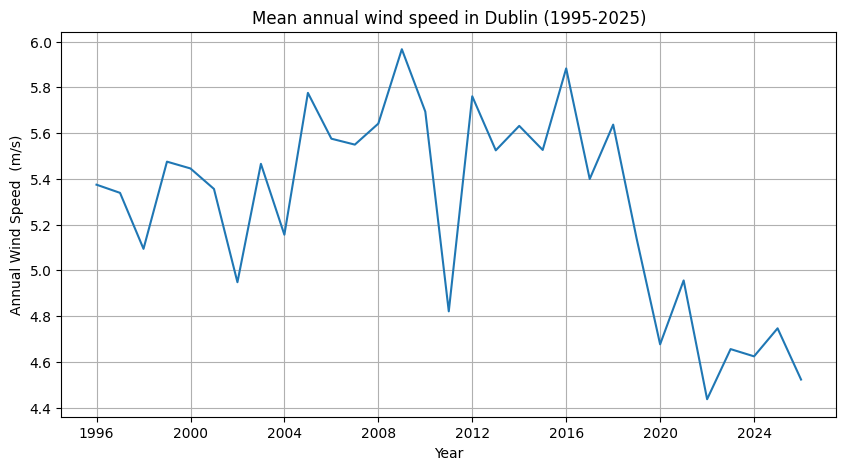

In [59]:
plt.figure(figsize=(10,5))
plt.plot(df_yearly.index, df_yearly.values)
plt.xlabel("Year")
plt.ylabel("Annual Wind Speed  (m/s)")
plt.title("Mean annual wind speed in Dublin (1995-2025)")
plt.grid(True)
plt.show()

The previous graph shows the overall wind behavior. It's the average wind speed throughout the year. It's calculated using many measurements (daily or hourly).

It represents how windy the typical weather is. meaning it reflects how the wind was most of the time.

We can visualize the historical distribution of wind speed during the last 30 years.

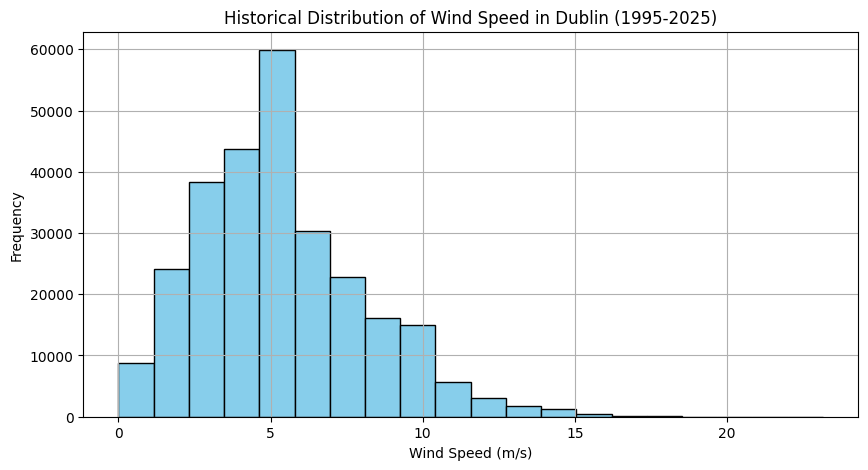

In [60]:
# historical distribution of wind speed
plt.figure(figsize=(10,5))
plt.hist(df['mean wind speed'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Historical Distribution of Wind Speed in Dublin (1995-2025)")
plt.grid(True)
plt.show()

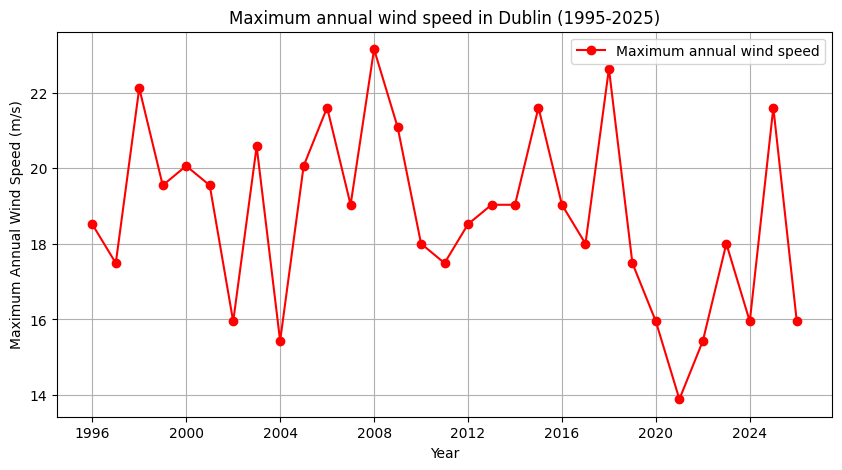

In [61]:
# Plot the maximum anual speed

# Group by year and calculate maximum annual wind speed
'''using YE instead of 'Y', as it will be deprecated in future versions'''
df_yearly_max = df.resample('YE')['mean wind speed'].max()

# Plot the maximum annual wind speed
plt.figure(figsize=(10,5))
plt.plot(df_yearly_max.index, df_yearly_max.values, marker='o', color='red', label='Maximum annual wind speed')
plt.xlabel("Year")
plt.ylabel("Maximum Annual Wind Speed (m/s)")
plt.title("Maximum annual wind speed in Dublin (1995-2025)")
plt.grid(True)
plt.legend()
plt.show()

From the graph above, we can observe a range of values, approximately between 14 m/s and 23 m/s, which indicates significant fluctuations in extreme wind events.

1997, 2008, and 2018 show some of the highest values, exceeding 22 m/s.

The absolute maximum appears to have occurred around 2008, close to 23 m/s, suggesting a year with particularly intense wind events.

The maximum annual wind in Dublin shows irregular behavior, typical of extreme weather phenomena.

We can delve deeper by analysing whether wind speed can change during any period of the year, for example, a specific season.

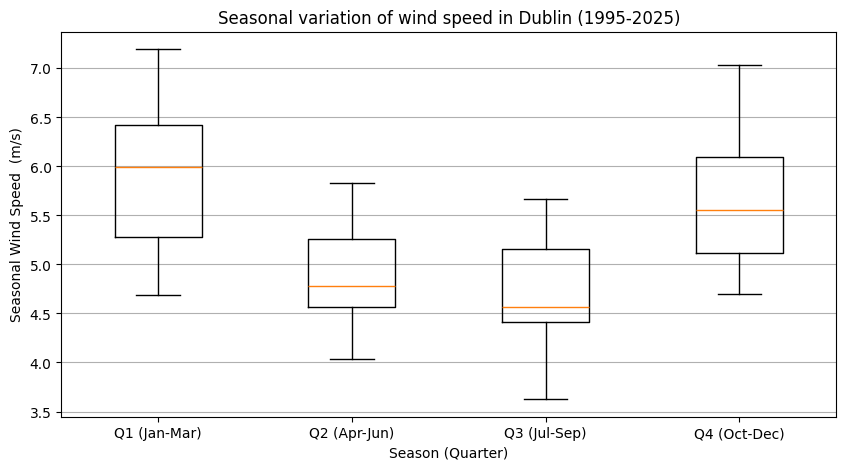

In [62]:
# season analysis of wind speed
'''using QE instad 'Q' as it will be deprecated in future versions'''
''' We use 'Q' to group by quarter'''
df_seasonal = df.resample('QE')
windspeed_mean = df_seasonal['mean wind speed'].mean()
windspeed_mean.head()

# plot the seasonal data as boxplot grouped by quarter

plt.figure(figsize=(10,5))
# Extract quarter from index and prepare data for boxplot
windspeed_df = windspeed_mean.reset_index()
windspeed_df['quarter'] = windspeed_df['date and time'].dt.quarter

# Group by quarter and create boxplot
data_by_quarter = [windspeed_df[windspeed_df['quarter'] == q]['mean wind speed'].values 
                   for q in [1, 2, 3, 4]]
plt.boxplot(data_by_quarter, tick_labels=['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
plt.xlabel("Season (Quarter)")
plt.ylabel("Seasonal Wind Speed  (m/s)")
plt.title("Seasonal variation of wind speed in Dublin (1995-2025)")
plt.grid(True, axis='y')
plt.show()


From the boxplot above, we can see that the fastest (strongest) winds are in the winter quarter, and the slowest are in summer. 
The wind speed order by season (going from fastest to slowest) are:
- Q1 (Winter): median - 6.0 m/s

- Q4 (Autumn): median - 5.5–5.6 m/s

- Q2 (Spring): median - 4.8 m/s

- Q3 (Summer): median - 4.5–4.6 m/s

The height of the boxes (IQR) indicates:

- Greater variability in winter and autumn

- More storms and fronts

- Less variability in summer

- More stable conditions


The whiskers indicates:

- Q1 and Q4 reach maximums close to 7–7.2 m/s.

- Q3 has lower minimums (3.6–3.7 m/s).

Interpretation:

Strong wind events are concentrated in cold months.

Calm conditions predominate in summer.

Now we can check the tendency during these three decades. This can help us understand the changes over time, whether these values are trending, decreased or stable.

In [63]:
# Calculate the tendency
nineties_wind = df_yearly.loc['1995':'2005'].mean()
late_wind  = df_yearly.loc['2015':'2025'].mean()

trend = (late_wind - nineties_wind) / 20
print(f"The tendency of wind speed in Dublin is {trend:.2f} m/s per year.")

The tendency of wind speed in Dublin is -0.02 m/s per year.


In [64]:
# Calculate the tendency per decade
trend_decade = trend * 10
print(f"The tendency of wind speed in Dublin is {trend_decade:.2f} m/s per decade.")

The tendency of wind speed in Dublin is -0.20 m/s per decade.


We can calculate the tendency per 30 years, to verify visualy how the values are during these three decades.

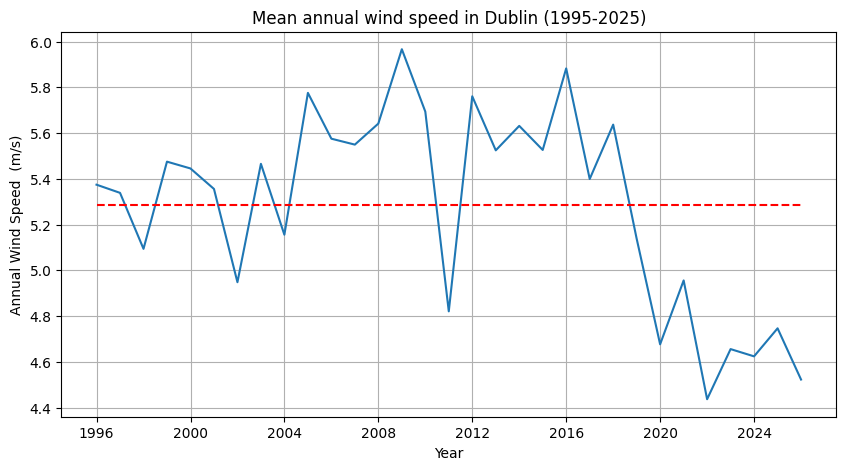

In [65]:
# plot the tendency
plt.figure(figsize=(10,5))
plt.plot(df_yearly.index, df_yearly.values, label='Mean annual wind speed')
early = df_yearly.loc['1995':'2025']
mean_early = early.mean()
plt.hlines(mean_early, early.index.min(), early.index.max(),
           linestyles='--', color='red', label="Media 1995–2025")
plt.xlabel("Year")
plt.ylabel("Annual Wind Speed  (m/s)")
plt.title("Mean annual wind speed in Dublin (1995-2025)")
plt.grid(True)

From the previous graph we can see the average annual speed ranges is approximately between 4.4 m/s and 6.0 m/s.

From approximately 2016 onward, the trend has been going down.
Most recent years have been below the historical average, suggesting a weakening of average wind speeds in Dublin over the past decade.

End